Observations:


1.   In Graphs, the GNN without training produces accuracy equivalent to random accuracy. Whereas CNNs produce accuracy way better than random. May be thats why in images distribution matching can be used but in Graphs it may not be useful.
2.   


In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE

In [ ]:
print(torch.__version__)

2.1.0+cu121


In [ ]:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 34.1 MB/s eta 0:00:00


In [ ]:
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# !pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00


In [ ]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from torch_geometric.nn import GATConv
from sklearn.decomposition import PCA
import numpy as np

In [ ]:
# plot PCA and TSNE both

def visualize_embedding( X, color,epoch=None, loss=None ):
    #PCA
    X = X.detach().cpu().numpy()
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    h = pca.transform(X)

    #plot 2D
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    #h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=5)
    X_tsne = tsne.fit_transform(X)

    # Plot the result
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap="Set2")
    plt.show()

    return

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_feature, nclasses):
    super().__init__()
    torch.manual_seed(10)
    self.input_feature = input_feature
    self.nclasses = nclasses
    #define layers
    self.conv1 = GCNConv(in_channels=self.input_feature,out_channels=1024)
    self.conv2 = GCNConv(in_channels=1024, out_channels=512)
    self.conv3 = GCNConv(in_channels= 512, out_channels=512)
    self.classifier = Linear(512,self.nclasses)

    def forward(self,x, edge_idx):
    a = self.conv1(x,edge_idx)
    a= a.tanh()
    a = self.conv2(a,edge_idx)
    a = a.tanh()
    a = self.conv3(a,edge_idx)
    a= a.tanh()
    out = self.classifier(a)

    return out,a

    class GAT(torch.nn.Module):
    def __init__(self, input_feature, nclasses):
    super().__init__()
    torch.manual_seed(10)
    self.input_feature = input_feature
    self.nclasses = nclasses
    #define layers
    self.conv1 = GATConv(in_channels=self.input_feature,out_channels=1024)
    self.conv2 = GATConv(in_channels=1024, out_channels=512)
    self.conv3 = GATConv(in_channels= 512, out_channels=512)
    self.classifier = Linear(512,self.nclasses)

    def forward(self,x, edge_idx):
    a = self.conv1(x,edge_idx)
    a= a.tanh()
    a = self.conv2(a,edge_idx)
    a = a.tanh()
    a = self.conv3(a,edge_idx)
    a= a.tanh()
    out = self.classifier(a)

    return out,a

In [ ]:
data = Planetoid(root='data', name= "cora")
print("no of features", data.num_features)
print("no of classes", data.num_classes)
model = GCN(data.num_features,data.num_classes)
model

Processing...


no of features 1433
no of classes 7


Done!


GCN(
  (conv1): GCNConv(1433, 1024)
  (conv2): GCNConv(1024, 512)
  (conv3): GCNConv(512, 512)
  (classifier): Linear(in_features=512, out_features=7, bias=True)
)


#  Exp: How does GNN perform without Training?



In [ ]:
# forward pass - How do the probabilities look for data points without training
prob, embed = model(data.x, data.edge_index)
findprob = torch.nn.Softmax(dim=1)
nprob = findprob(prob)
trainmask = data.train_mask
len(nprob[trainmask,1])
print("Visualizing prob[0]",prob[0] )

# probability of being in class 1
print("probability of training points to be in class 1", nprob[trainmask,1])

print("shape of probability", nprob.shape)
accurate_pred=sum(torch.argmax(nprob,dim=1)[trainmask] == data.y[trainmask])
print("number of accurate points",accurate_pred)
print("random probability",1/7)
print("Number of feature",data.num_features)

# Exp : Finding boundary and centerpoints


1. Train model and get embedding
2. FOR EACH CLASS: Create buckets based on probability - So we can get boundary points and center point.
3. Train model with boundary points and then train it with center points. Results
4. Train the model by picking 1 point from each bucket and check the results.




In [ ]:
class training():
    def __init__(self, model, data, mask = None):
        self.model = model
        self.dataset = data
        self.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00012)  # Define optimizer.
        if mask == None:
            self.train_old_mask = self.dataset.data.train_mask
        else:
            self.train_old_mask = mask
            self.dataset.data.train_mask = mask
        self.embed = 0


    def train(self, data):
        self.optimizer.zero_grad()  # Clear gradients.
        out, h = self.model.forward(data.x, data.edge_index)  # Perform a single forward pass.

        loss = self.criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

        loss.backward()  # Derive gradients.
        self.optimizer.step()  # Update parameters based on gradients.
        return loss, h, out

    def train_model(self, epo=100):
        
        data = self.dataset[0]
        #print("Shape is', data.x.shape)
        loss_t = []

        train_loss = []
        val_loss = []
        test_loss = []

        test_accuracy = []
        train_accuracy = []
        val_accuracy = []

        ep=[]

        macro_f1_train = []
        macro_f1_val =[]
        macro_f1_test=[]

        print('Training Started...')
        for epoch in range(1,epo):
            loss, h, out = self.train(data)
            loss_t+=[loss]

            if epoch % 5 == 0:
                #visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
                ep.append(epoch)

                with torch.no_grad():
                    
                    train_loss.append(self.criterion(out[data.train_mask], data.y[data.train_mask]).item())
                    val_loss.append(self.criterion(out[data.val_mask], data.y[data.val_mask]).item())
                    test_loss.append(self.criterion(out[data.test_mask], data.y[data.test_mask]).item())

                    train_accuracy.append(((torch.argmax(out[data.train_mask], axis=1) == data.y[data.train_mask]).sum()/len(data.y[data.train_mask])).item()*100)
                    val_accuracy.append(((torch.argmax(out[data.val_mask], axis=1) == data.y[data.val_mask]).sum()/len(data.y[data.val_mask])).item()*100)
                    test_accuracy.append(((torch.argmax(out[data.test_mask], axis=1) == data.y[data.test_mask]).sum()/len(data.y[data.test_mask])).item()*100)

                  # macro_f1_train.append(f1_score(data.y[data.train_mask].cpu(), torch.argmax(out[data.train_mask].cpu(), axis=1), average='macro'))
                  # macro_f1_val.append(f1_score(data.y[data.val_mask].cpu(), torch.argmax(out[data.val_mask].cpu(), axis=1), average='macro'))
                  # macro_f1_test.append(f1_score(data.y[data.test_mask].cpu(), torch.argmax(out[data.test_mask].cpu(), axis=1), average='macro'))
                  #print('Epoch : ', epoch, " Test Accuracy: ", test_accuracy[-1], "MacroF1 train: ",macro_f1_train[-1], "MacroF1 Val: ",macro_f1_val[-1])
                    print(f'Epoch : {epoch:.2f}, Training Accuracy: {train_accuracy[-1]:.2f}, Testing Accuracy: {test_accuracy[-1]:.2f}')
                  #print("train loss", loss.item(), "Val loss: ", val_loss[-1])

                #time.sleep(0.3)
        print('Training Finished!')
        with torch.no_grad():
            self.embed = h
            plt.figure(figsize=(9,6))
            plt.plot(ep, train_loss)
            plt.plot(ep, val_loss)
            plt.plot(ep, test_loss)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.grid(True, linestyle='--')
            plt.legend(['Training Loss','Validation Loss', 'Testing Loss'])
            plt.title('Loss Evolution')
            plt.show()
            visualize_embedding(self.embed, color=data.y, epoch=epoch, loss=loss)

In [ ]:
data = Planetoid(root='data', name= "cora")
model = GAT(data.num_features,data.num_classes)


Processing...
Done!


### Experiment with Cora

In [ ]:
exp = training(model, data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 76.50
Epoch : 40.00, Training Accuracy: 96.43, Testing Accuracy: 80.00
Epoch : 60.00, Training Accuracy: 99.29, Testing Accuracy: 80.50
Epoch : 80.00, Training Accuracy: 100.00, Testing Accuracy: 79.90
Training Finished!


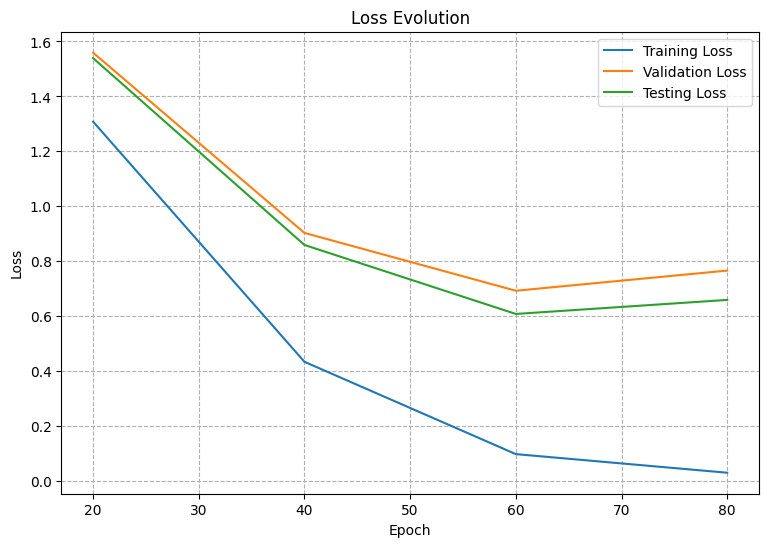

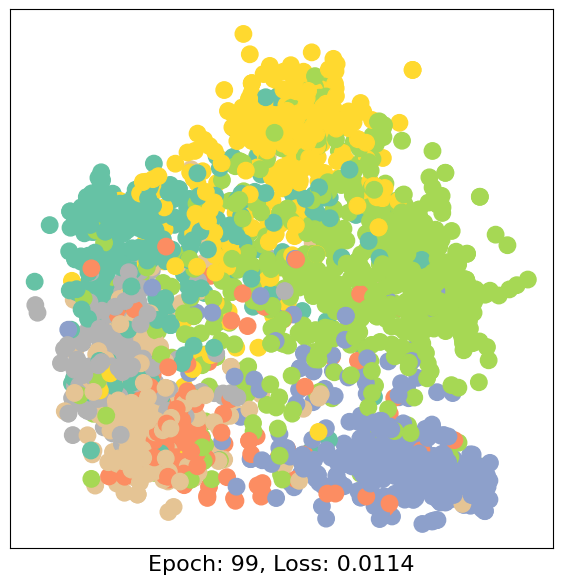

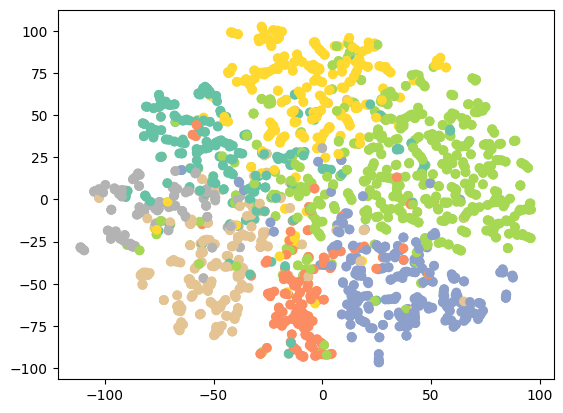

In [ ]:
exp.train_model()

In [ ]:
#make an eval model and convert dataset to data
exp.model.eval()
data= data[0]

In [ ]:
# need a forward pass to find score and embed
score, embed = exp.model.forward(data.x, data.edge_index)

In [ ]:
# need to apply softmax to convert scores to probability
runsoftmax = torch.nn.Softmax(dim=1)
nprob = runsoftmax(score)
trainmask = data.train_mask

In [ ]:
# probability of only the training data points
nprob_train = nprob[trainmask]
nprob_train.shape

torch.Size([140, 7])

In [ ]:
target_class = 6     # select from 0 to 6
prob = nprob_train[data.y[trainmask]==target_class]
prob.shape

torch.Size([20, 7])

In [ ]:
prob[:,target_class]

tensor([0.9945, 0.9992, 0.9951, 0.9850, 0.9988, 0.9959, 0.9602, 0.9906, 0.9982,
        0.9977, 0.9755, 0.9981, 0.9993, 0.9982, 0.9923, 0.9883, 0.9669, 0.9992,
        0.9993, 0.9993], grad_fn=<SelectBackward0>)

FOR Cora dataset, All the train data points are producing high probability. The training accuracy is 100%. How to find boundary points in this case?

Exp with citeseer

In [ ]:
data = Planetoid(root='data', name= "citeseer")
model = GAT(data.num_features,data.num_classes)

Processing...
Done!


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 95.00, Testing Accuracy: 69.00
Training Finished!


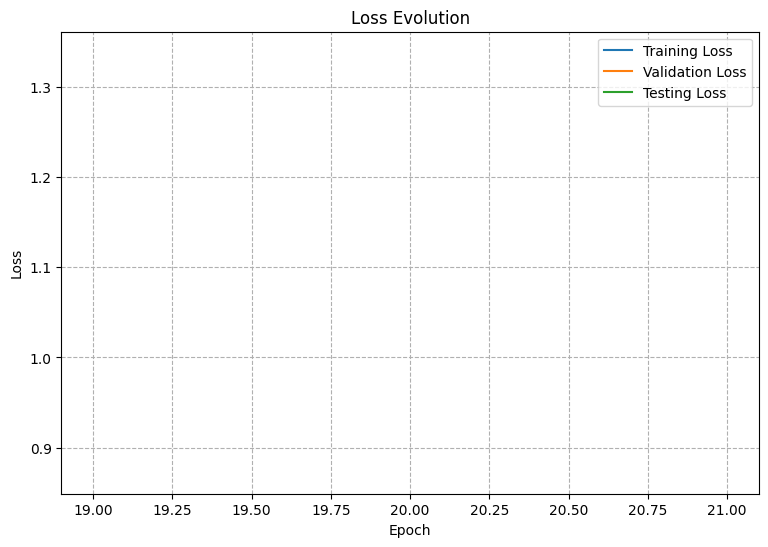

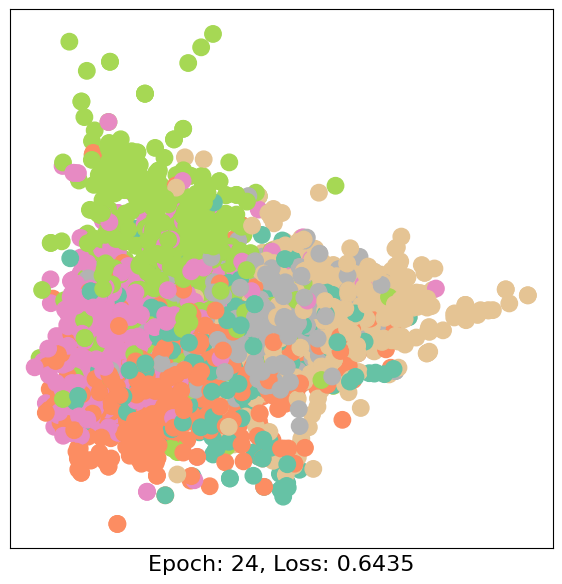

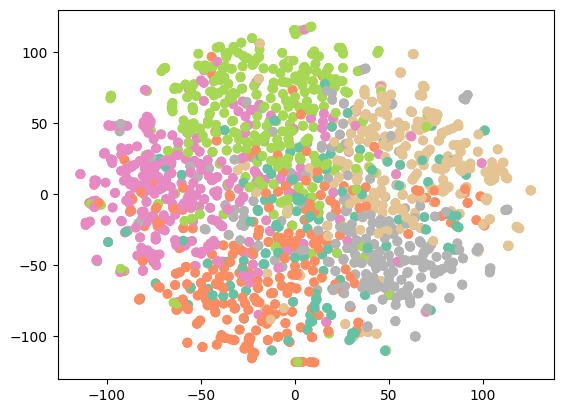

In [ ]:
exp = training(model, data)
exp.train_model(epo=25)

In [ ]:
#make an eval model and convert dataset to data
exp.model.eval()
data= data[0]

# need a forward pass to find score and embed
score, embed = exp.model.forward(data.x, data.edge_index)

# need to apply softmax to convert scores to probability
runsoftmax = torch.nn.Softmax(dim=1)
nprob = runsoftmax(score)
trainmask = data.train_mask

# probability of only the training data points
nprob_train = nprob[trainmask]
nprob_train.shape


torch.Size([120, 6])

In [ ]:
data.y.shape

torch.Size([3327])

In [ ]:
target_class = 4     # select from 0 to 5
prob = nprob_train[data.y[trainmask]==target_class]
prob.shape

torch.Size([20, 6])

In [ ]:
prob[:,target_class]

tensor([0.8061, 0.7925, 0.6250, 0.4287, 0.4457, 0.7086, 0.5161, 0.7676, 0.8830,
        0.7110, 0.7264, 0.5867, 0.6387, 0.5668, 0.6520, 0.6755, 0.5189, 0.6519,
        0.3500, 0.4444], grad_fn=<SelectBackward0>)

In [ ]:
import numpy as np
np.histogram(prob[:,target_class].detach(), bins = 3)

(array([6, 7, 7]),
 array([0.34998545, 0.5276544 , 0.7053234 , 0.8829924 ], dtype=float32))

In [ ]:
# For all nodes classified by model in that class, pick one lowest probability and one highest probability node.
# Finally train using 2 nodes per classs.

In [ ]:
# def calculate_entropy(probabilities):
#     # Avoid logarithm of zero and negative values
#     probabilities = np.maximum(probabilities, 1e-10)

#     # Calculate entropy for each data point
#     entropy_values = -np.sum(probabilities * np.log2(probabilities), axis=1)

#     # Reshape the entropy values to (n, 1) tensor
#     entropy_tensor = entropy_values.reshape(-1, 1)

#     return entropy_tensor

In [ ]:
def find_new_mask(nprob_train,nsamples=1):

  # Calculate entropy for each data point
  entropy_data = -torch.sum(nprob_train * torch.log2(nprob_train + 1e-10), dim=1)   #1e-10 so that there are no very small numbers

  # Find indices of data points with highest and lowest entropy for each class
  # highest_entropy_indices_per_class = []
  # lowest_entropy_indices_per_class = []

    # Create new train masks with only highest and lowest entropy points set to True
  new_high_train_mask = torch.zeros_like(trainmask)
  new_low_train_mask = torch.zeros_like(trainmask)

  for class_id in range(nprob_train.shape[1]):  # Iterate over each class
      class_mask = data.y[trainmask] == class_id
      class_entropies = entropy_data[class_mask]

      # Find indices of highest and lowest entropies for the current class
      highest_indices = torch.argsort(class_entropies, descending=True)[:nsamples]
      lowest_indices = torch.argsort(class_entropies)[:nsamples]
      print(highest_indices, len(new_high_train_mask[trainmask][data.y[trainmask] == class_id][highest_indices]))
      print(lowest_indices, len(new_low_train_mask[trainmask][data.y[trainmask] == class_id][lowest_indices]))

      new_high_indices = torch.nonzero(class_mask)[highest_indices]  # Indices in the original tensor
      new_low_indices = torch.nonzero(class_mask)[lowest_indices]  # Indices in the original tensor

      new_high_train_mask[new_high_indices] = 1
      new_low_train_mask[new_low_indices] = 1

      # new_high_train_mask[trainmask][data.y[trainmask] == class_id][highest_indices] = 1
      # new_low_train_mask[trainmask][data.y[trainmask] == class_id][lowest_indices] = 1
      print(sum(new_high_train_mask), sum(new_low_train_mask))


  print("New train mask for highest entropy points per class:\n", sum(new_high_train_mask))
  print("New train mask for lowest entropy points per class:\n", sum(new_low_train_mask))
  full_mask = torch.logical_or(new_low_train_mask, new_high_train_mask)

  return new_high_train_mask, new_low_train_mask, full_mask


In [ ]:
highmask, lowmask, fullmask = find_new_mask(nprob_train,5)

tensor([15,  7, 10,  3,  4]) 5
tensor([ 9, 19,  6,  1, 14]) 5
tensor(5) tensor(5)
tensor([12,  4,  7, 14,  1]) 5
tensor([ 6,  2, 15, 11, 17]) 5
tensor(10) tensor(10)
tensor([13, 10, 18, 16, 11]) 5
tensor([ 9,  4,  7,  5, 12]) 5
tensor(15) tensor(15)
tensor([13, 17,  1, 16, 11]) 5
tensor([10,  7,  8, 15,  0]) 5
tensor(20) tensor(20)
tensor([10,  9,  2, 17,  1]) 5
tensor([15, 11,  3,  0,  8]) 5
tensor(25) tensor(25)
tensor([ 6,  1,  0,  3, 10]) 5
tensor([ 2, 16, 19,  4,  5]) 5
tensor(30) tensor(30)
tensor([ 6, 16, 10,  3, 15]) 5
tensor([19, 18, 12,  1, 17]) 5
tensor(35) tensor(35)
New train mask for highest entropy points per class:
 tensor(35)
New train mask for lowest entropy points per class:
 tensor(35)


In [ ]:
highmask3, lowmask3, _ = find_new_mask(nprob_train,3)
highmask2, lowmask2, _ = find_new_mask(nprob_train,2)

tensor([15,  7, 10]) 3
tensor([ 9, 19,  6]) 3
tensor(3) tensor(3)
tensor([12,  4,  7]) 3
tensor([ 6,  2, 15]) 3
tensor(6) tensor(6)
tensor([13, 10, 18]) 3
tensor([9, 4, 7]) 3
tensor(9) tensor(9)
tensor([13, 17,  1]) 3
tensor([10,  7,  8]) 3
tensor(12) tensor(12)
tensor([10,  9,  2]) 3
tensor([15, 11,  3]) 3
tensor(15) tensor(15)
tensor([6, 1, 0]) 3
tensor([ 2, 16, 19]) 3
tensor(18) tensor(18)
tensor([ 6, 16, 10]) 3
tensor([19, 18, 12]) 3
tensor(21) tensor(21)
New train mask for highest entropy points per class:
 tensor(21)
New train mask for lowest entropy points per class:
 tensor(21)
tensor([15,  7]) 2
tensor([ 9, 19]) 2
tensor(2) tensor(2)
tensor([12,  4]) 2
tensor([6, 2]) 2
tensor(4) tensor(4)
tensor([13, 10]) 2
tensor([9, 4]) 2
tensor(6) tensor(6)
tensor([13, 17]) 2
tensor([10,  7]) 2
tensor(8) tensor(8)
tensor([10,  9]) 2
tensor([15, 11]) 2
tensor(10) tensor(10)
tensor([6, 1]) 2
tensor([ 2, 16]) 2
tensor(12) tensor(12)
tensor([ 6, 16]) 2
tensor([19, 18]) 2
tensor(14) tensor(14)
N

In [ ]:
high3low2 = torch.logical_or(highmask3, lowmask2)
high2low3 = torch.logical_or(highmask2, lowmask3)

In [ ]:
# use only highmask
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, highmask)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 60.00
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 66.00
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 62.90
Epoch : 80.00, Training Accuracy: 100.00, Testing Accuracy: 62.00
Training Finished!


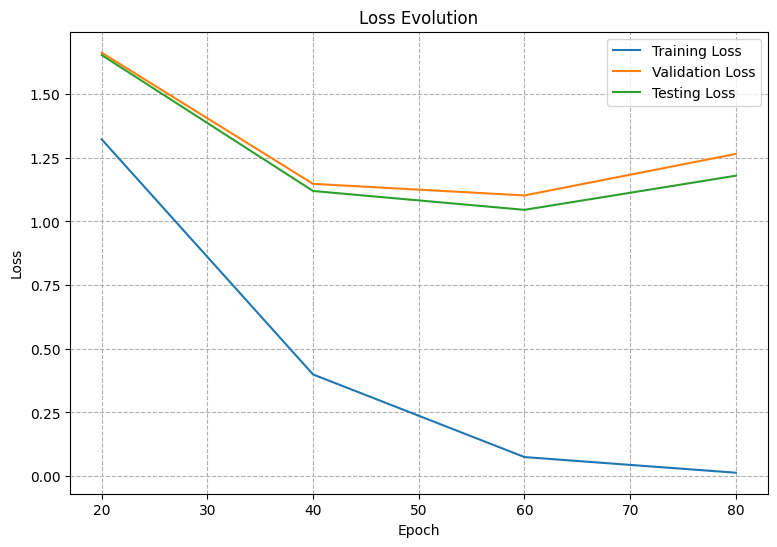

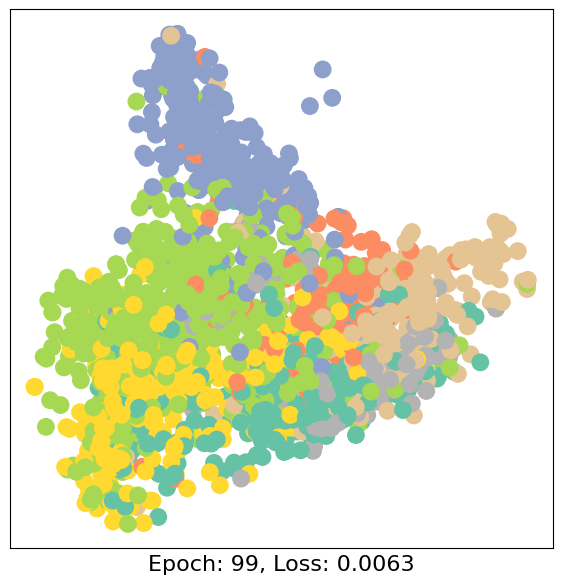

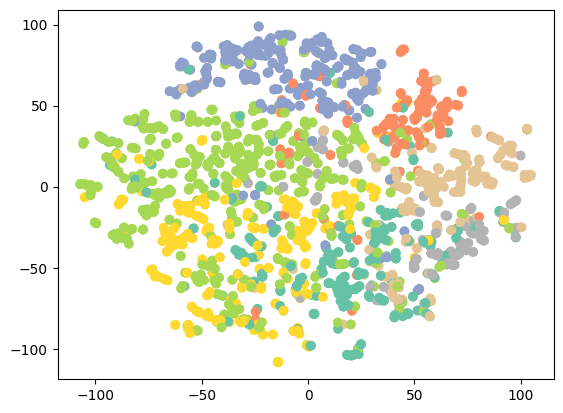

In [ ]:
exp_new_mask.train_model()

In [ ]:
#with only low mask
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, lowmask)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 100.00, Testing Accuracy: 63.50
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 65.10
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 64.90
Epoch : 80.00, Training Accuracy: 100.00, Testing Accuracy: 66.10
Training Finished!


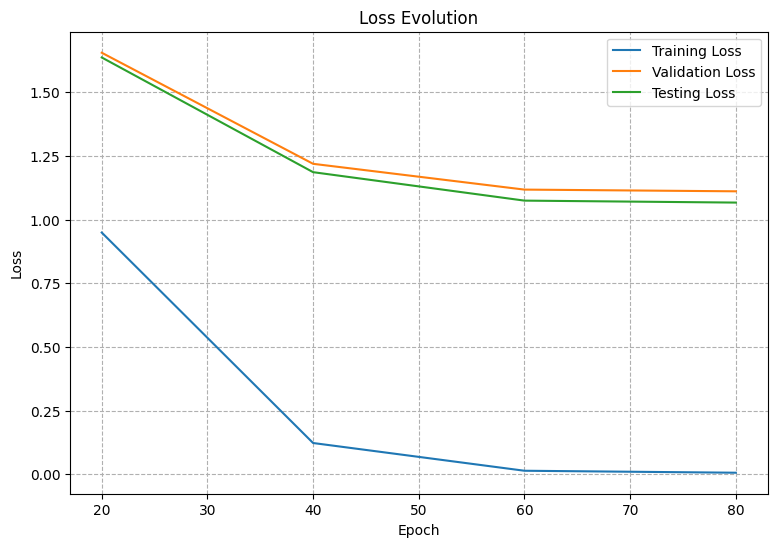

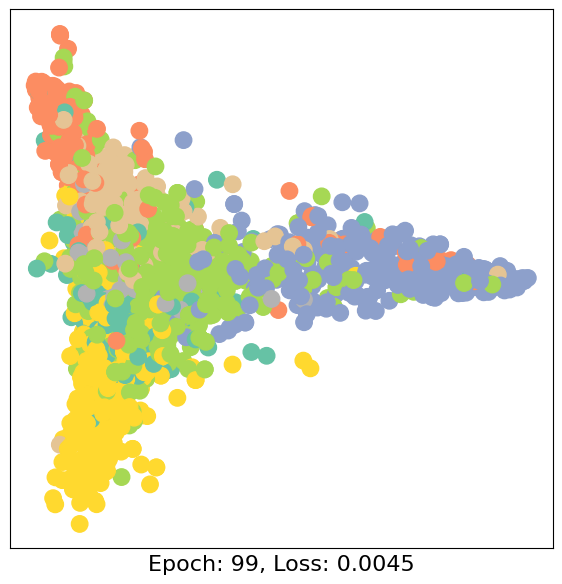

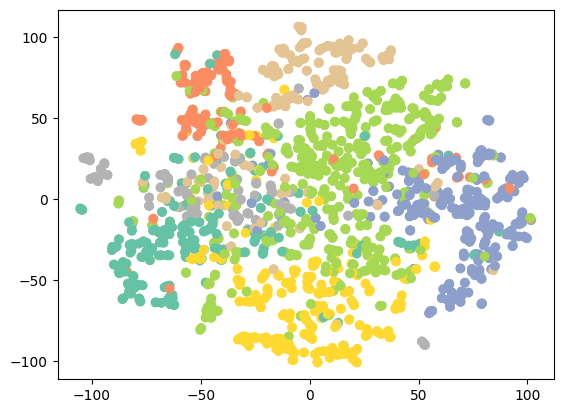

In [ ]:
exp_new_mask.train_model()

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high2low3)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 91.43, Testing Accuracy: 63.10
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 68.80
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 66.90
Epoch : 80.00, Training Accuracy: 100.00, Testing Accuracy: 64.90
Training Finished!


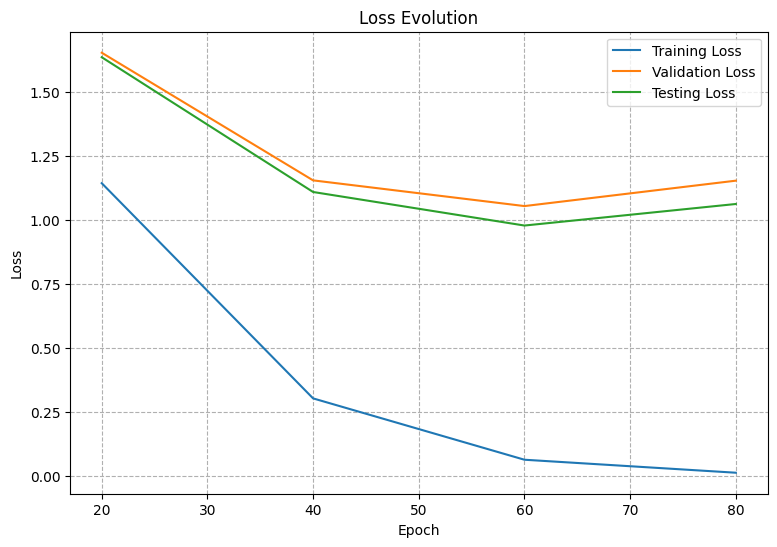

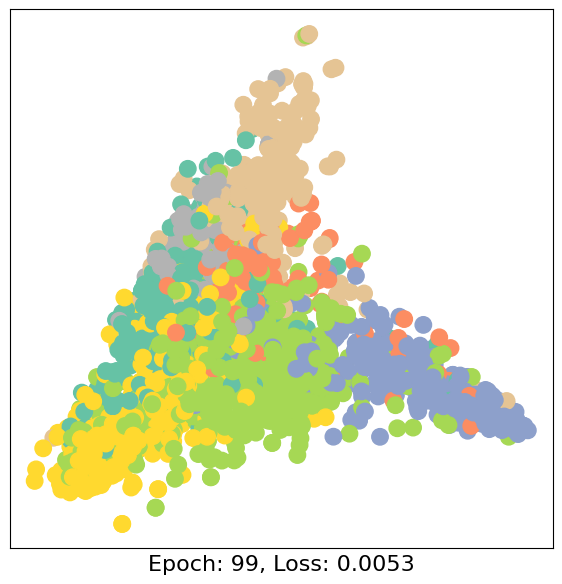

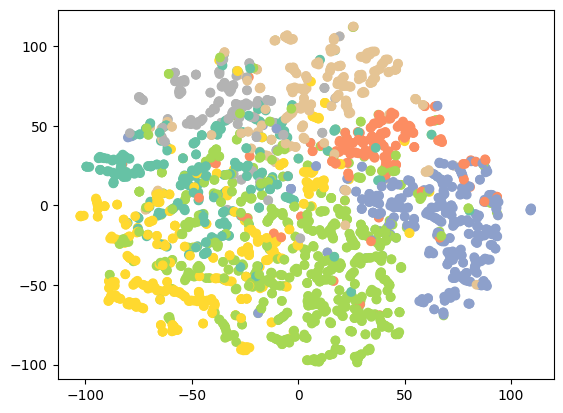

In [ ]:
exp_new_mask.train_model()

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high3low2)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 62.00
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 68.60
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 65.80
Epoch : 80.00, Training Accuracy: 100.00, Testing Accuracy: 62.20
Training Finished!


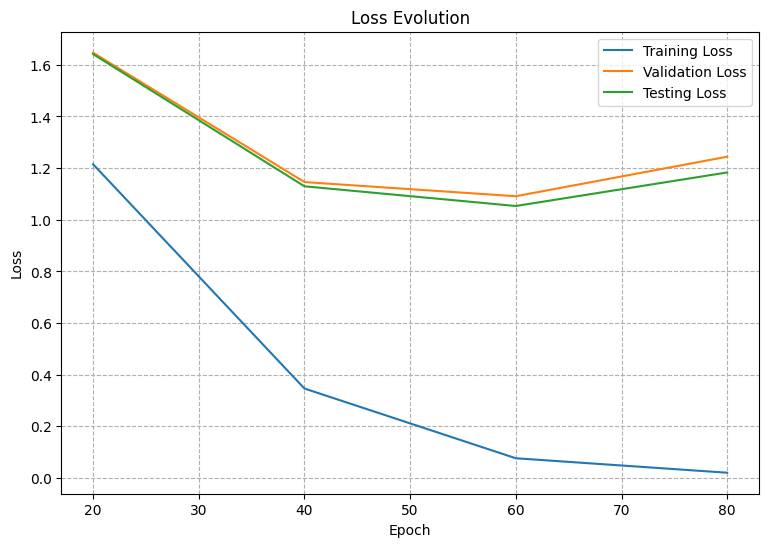

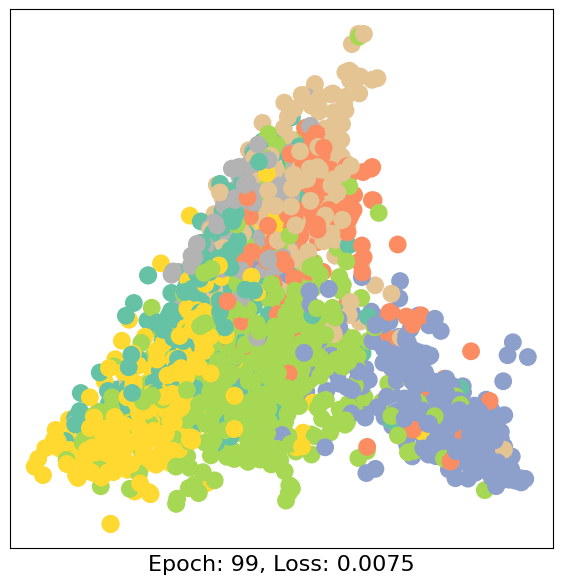

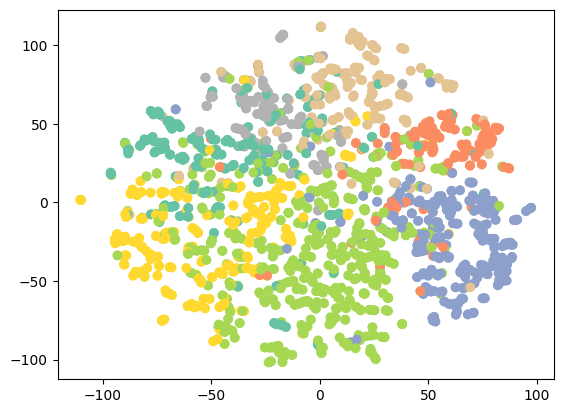

In [ ]:
exp_new_mask.train_model()

In [ ]:
highmask1, lowmask1, _ = find_new_mask(nprob_train,1)
highmask4, lowmask4, _ = find_new_mask(nprob_train,4)
high4low1 = torch.logical_or(highmask4, lowmask1)
high1low4 = torch.logical_or(highmask1, lowmask4)

tensor([15]) 1
tensor([9]) 1
tensor(1) tensor(1)
tensor([12]) 1
tensor([6]) 1
tensor(2) tensor(2)
tensor([13]) 1
tensor([9]) 1
tensor(3) tensor(3)
tensor([13]) 1
tensor([10]) 1
tensor(4) tensor(4)
tensor([10]) 1
tensor([15]) 1
tensor(5) tensor(5)
tensor([6]) 1
tensor([2]) 1
tensor(6) tensor(6)
tensor([6]) 1
tensor([19]) 1
tensor(7) tensor(7)
New train mask for highest entropy points per class:
 tensor(7)
New train mask for lowest entropy points per class:
 tensor(7)
tensor([15,  7, 10,  3]) 4
tensor([ 9, 19,  6,  1]) 4
tensor(4) tensor(4)
tensor([12,  4,  7, 14]) 4
tensor([ 6,  2, 15, 11]) 4
tensor(8) tensor(8)
tensor([13, 10, 18, 16]) 4
tensor([9, 4, 7, 5]) 4
tensor(12) tensor(12)
tensor([13, 17,  1, 16]) 4
tensor([10,  7,  8, 15]) 4
tensor(16) tensor(16)
tensor([10,  9,  2, 17]) 4
tensor([15, 11,  3,  0]) 4
tensor(20) tensor(20)
tensor([6, 1, 0, 3]) 4
tensor([ 2, 16, 19,  4]) 4
tensor(24) tensor(24)
tensor([ 6, 16, 10,  3]) 4
tensor([19, 18, 12,  1]) 4
tensor(28) tensor(28)
New train

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high4low1)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 94.29, Testing Accuracy: 49.60
Epoch : 10.00, Training Accuracy: 94.29, Testing Accuracy: 58.00
Epoch : 15.00, Training Accuracy: 94.29, Testing Accuracy: 62.30
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 66.00
Epoch : 25.00, Training Accuracy: 94.29, Testing Accuracy: 69.40
Epoch : 30.00, Training Accuracy: 97.14, Testing Accuracy: 70.30
Epoch : 35.00, Training Accuracy: 97.14, Testing Accuracy: 70.60
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 71.00
Epoch : 45.00, Training Accuracy: 97.14, Testing Accuracy: 71.30
Epoch : 50.00, Training Accuracy: 97.14, Testing Accuracy: 70.70
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 69.80
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 69.50
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 68.90
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 68.30
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 67.70
E

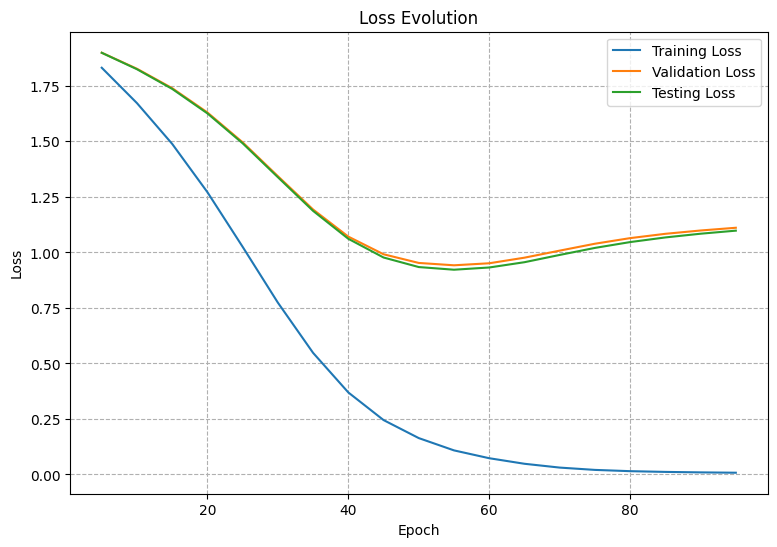

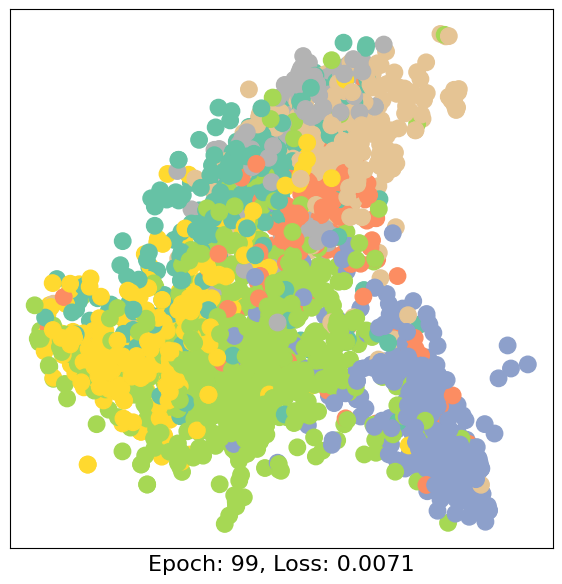

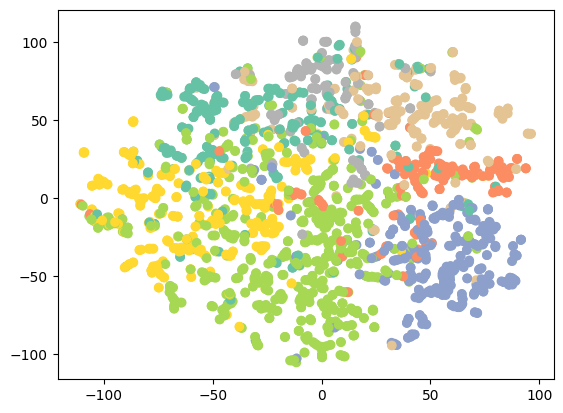

In [ ]:
exp_new_mask.train_model()

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high1low4)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 94.29, Testing Accuracy: 47.50
Epoch : 10.00, Training Accuracy: 94.29, Testing Accuracy: 55.70
Epoch : 15.00, Training Accuracy: 94.29, Testing Accuracy: 58.20
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 59.60
Epoch : 25.00, Training Accuracy: 94.29, Testing Accuracy: 61.00
Epoch : 30.00, Training Accuracy: 97.14, Testing Accuracy: 62.00
Epoch : 35.00, Training Accuracy: 97.14, Testing Accuracy: 63.10
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 65.10
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 66.20
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 66.60
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 66.40
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 66.20
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 65.10
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 64.40
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 63.60

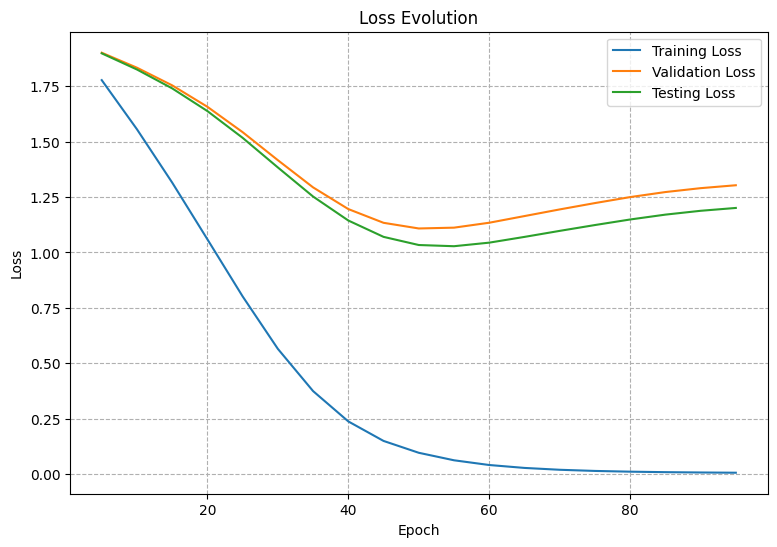

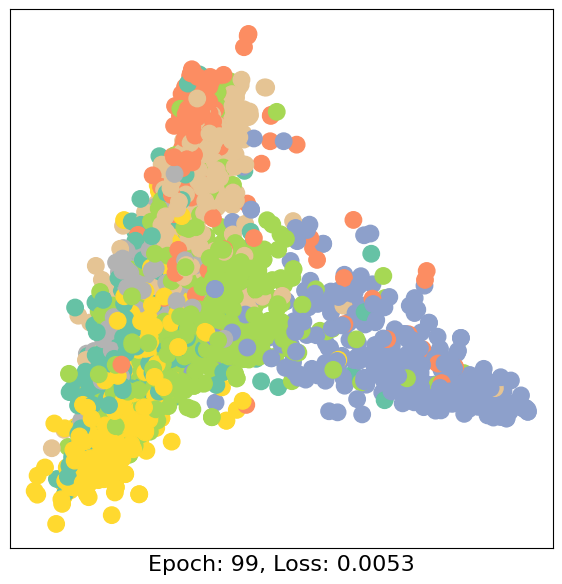

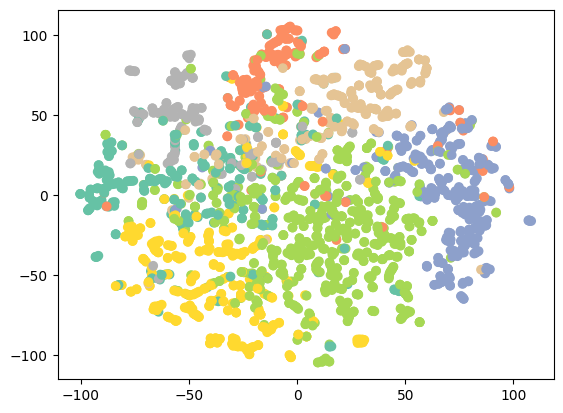

In [ ]:
exp_new_mask.train_model()

In [ ]:
highmask1, lowmask1, _ = find_new_mask(nprob_train,1)
highmask10, lowmask10, _ = find_new_mask(nprob_train,10)
highmask7, lowmask7, _ = find_new_mask(nprob_train,7)
highmask6, lowmask6, _ = find_new_mask(nprob_train,6)

highmask9, lowmask9, _ = find_new_mask(nprob_train,9)
highmask5, lowmask5, _ = find_new_mask(nprob_train,5)
highmask4, lowmask4, _ = find_new_mask(nprob_train,4)
highmask3, lowmask3, _ = find_new_mask(nprob_train,3)
highmask2, lowmask2, _ = find_new_mask(nprob_train,2)

tensor([15]) 1
tensor([9]) 1
tensor(1) tensor(1)
tensor([12]) 1
tensor([6]) 1
tensor(2) tensor(2)
tensor([13]) 1
tensor([9]) 1
tensor(3) tensor(3)
tensor([13]) 1
tensor([10]) 1
tensor(4) tensor(4)
tensor([10]) 1
tensor([15]) 1
tensor(5) tensor(5)
tensor([6]) 1
tensor([2]) 1
tensor(6) tensor(6)
tensor([6]) 1
tensor([19]) 1
tensor(7) tensor(7)
New train mask for highest entropy points per class:
 tensor(7)
New train mask for lowest entropy points per class:
 tensor(7)
tensor([15,  7, 10,  3,  4, 16,  8,  2,  5, 11]) 10
tensor([ 9, 19,  6,  1, 14,  0, 13, 17, 18, 12]) 10
tensor(10) tensor(10)
tensor([12,  4,  7, 14,  1, 13,  0,  9,  3, 16]) 10
tensor([ 6,  2, 15, 11, 17,  5,  8, 19, 18, 10]) 10
tensor(20) tensor(20)
tensor([13, 10, 18, 16, 11,  1,  0,  3, 14,  8]) 10
tensor([ 9,  4,  7,  5, 12,  6, 19, 15,  2, 17]) 10
tensor(30) tensor(30)
tensor([13, 17,  1, 16, 11,  5, 12,  3,  9, 19]) 10
tensor([10,  7,  8, 15,  0,  2,  6,  4, 18, 14]) 10
tensor(40) tensor(40)
tensor([10,  9,  2, 17,  

In [ ]:
a = torch.logical_or(highmask3, lowmask1)
a = torch.logical_or(a,torch.logical_xor(lowmask10,lowmask9))
#a = torch.logical_or(a, torch.logical_xor(highmask5,highmask4))
#a = torch.logical_or(a,torch.logical_xor(highmask3, highmask2))

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, a)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 85.71, Testing Accuracy: 49.30
Epoch : 10.00, Training Accuracy: 88.57, Testing Accuracy: 56.10
Epoch : 15.00, Training Accuracy: 91.43, Testing Accuracy: 61.80
Epoch : 20.00, Training Accuracy: 94.29, Testing Accuracy: 66.60
Epoch : 25.00, Training Accuracy: 94.29, Testing Accuracy: 70.50
Epoch : 30.00, Training Accuracy: 97.14, Testing Accuracy: 72.40
Epoch : 35.00, Training Accuracy: 97.14, Testing Accuracy: 73.20
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 72.30
Epoch : 45.00, Training Accuracy: 97.14, Testing Accuracy: 71.10
Epoch : 50.00, Training Accuracy: 97.14, Testing Accuracy: 70.20
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 70.30
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 69.90
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 69.20
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 68.70
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 68.50
E

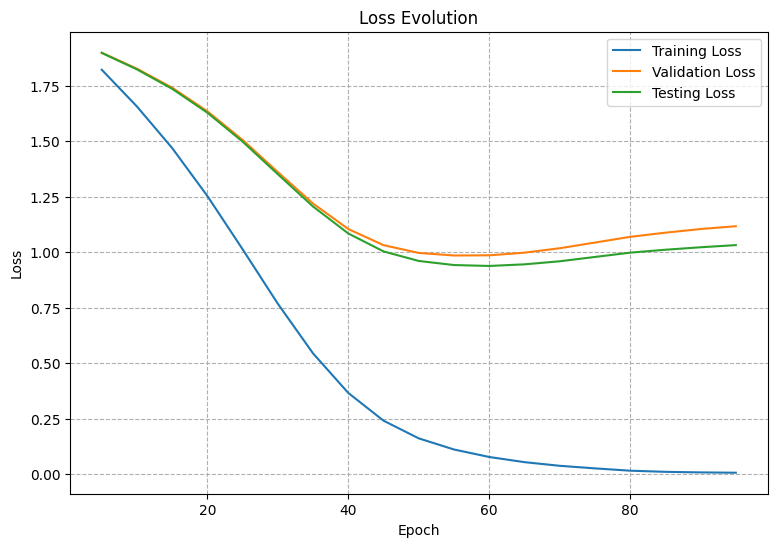

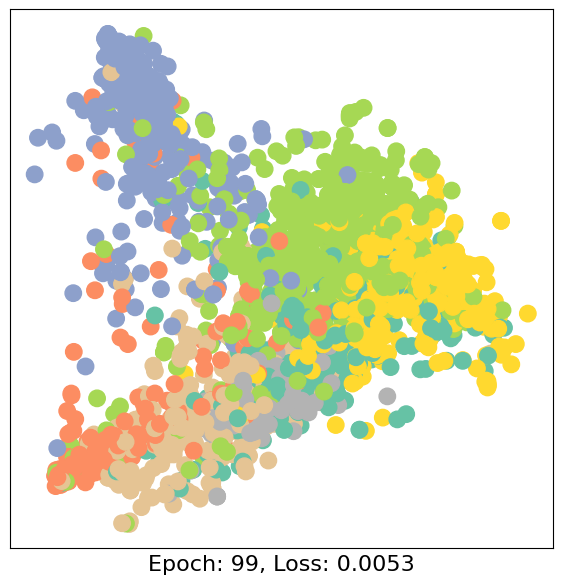

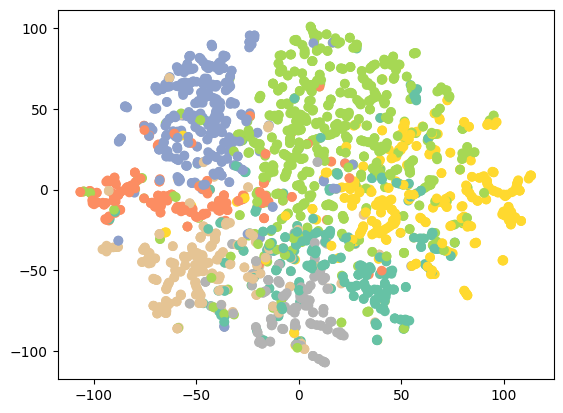

In [ ]:
exp_new_mask.train_model()

In [ ]:
a = torch.logical_or(highmask2, lowmask1)
a = torch.logical_or(a,torch.logical_xor(lowmask10,lowmask9))
a = torch.logical_or(a, torch.logical_xor(highmask7,highmask6))
#a = torch.logical_or(a,torch.logical_xor(highmask3, highmask2))

In [ ]:
# mix the high and low
data = Planetoid(root='data', name= "cora")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, a)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 88.57, Testing Accuracy: 53.40
Epoch : 10.00, Training Accuracy: 88.57, Testing Accuracy: 63.70
Epoch : 15.00, Training Accuracy: 88.57, Testing Accuracy: 69.70
Epoch : 20.00, Training Accuracy: 91.43, Testing Accuracy: 71.80
Epoch : 25.00, Training Accuracy: 91.43, Testing Accuracy: 73.40
Epoch : 30.00, Training Accuracy: 97.14, Testing Accuracy: 73.70
Epoch : 35.00, Training Accuracy: 97.14, Testing Accuracy: 73.80
Epoch : 40.00, Training Accuracy: 97.14, Testing Accuracy: 74.00
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 73.30
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 72.80
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 71.40
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 69.90
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 69.10
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 68.80
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 68.10

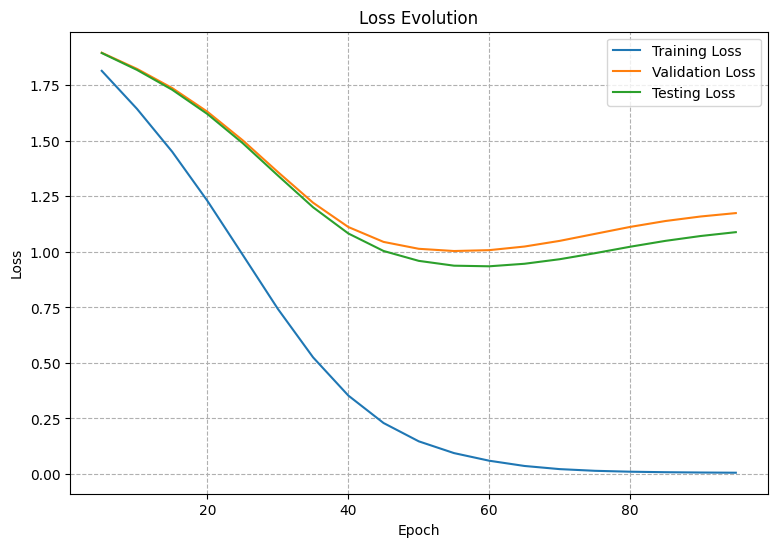

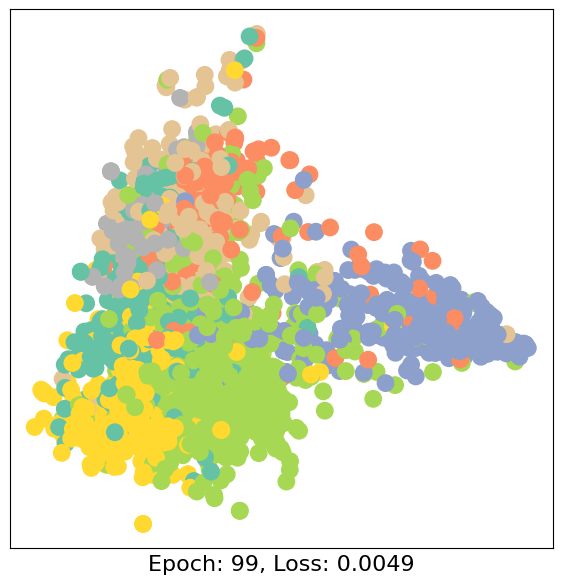

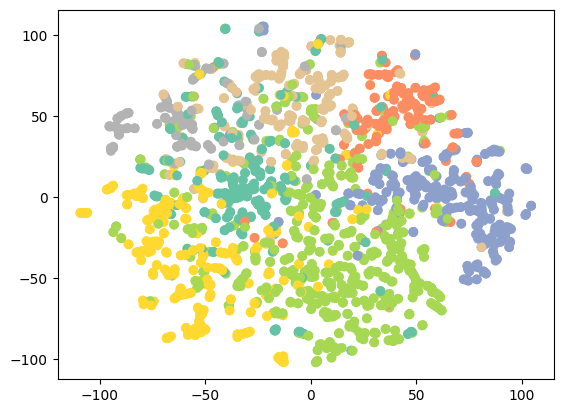

In [ ]:
exp_new_mask.train_model()

### Experiment with CiteSeer

In [ ]:
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)

In [ ]:
sum(data.train_mask)/6

tensor(20.)

In [ ]:
# train a model for embeddings
exp = training(model_new, data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 93.33, Testing Accuracy: 60.10
Epoch : 10.00, Training Accuracy: 94.17, Testing Accuracy: 68.40
Epoch : 15.00, Training Accuracy: 94.17, Testing Accuracy: 68.70
Epoch : 20.00, Training Accuracy: 95.00, Testing Accuracy: 69.00
Epoch : 25.00, Training Accuracy: 95.83, Testing Accuracy: 68.40
Epoch : 30.00, Training Accuracy: 95.83, Testing Accuracy: 67.60
Epoch : 35.00, Training Accuracy: 95.83, Testing Accuracy: 66.40
Epoch : 40.00, Training Accuracy: 99.17, Testing Accuracy: 66.50
Epoch : 45.00, Training Accuracy: 99.17, Testing Accuracy: 66.40
Epoch : 50.00, Training Accuracy: 99.17, Testing Accuracy: 66.20
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 65.90
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 66.20
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 65.10
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 65.60
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 65.70
E

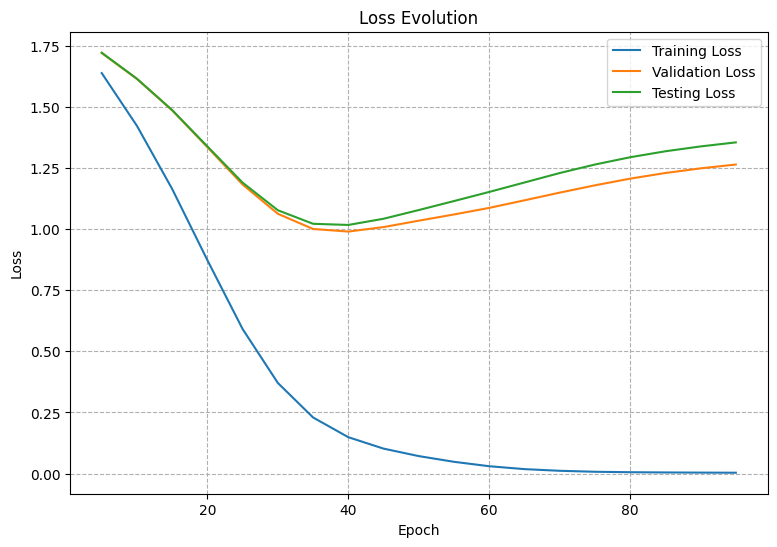

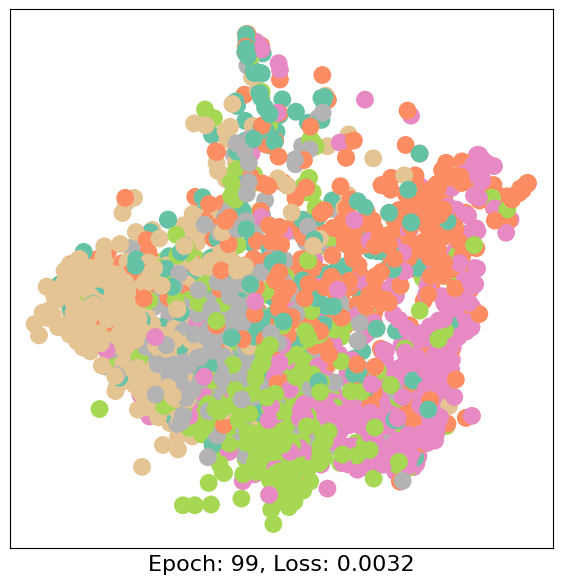

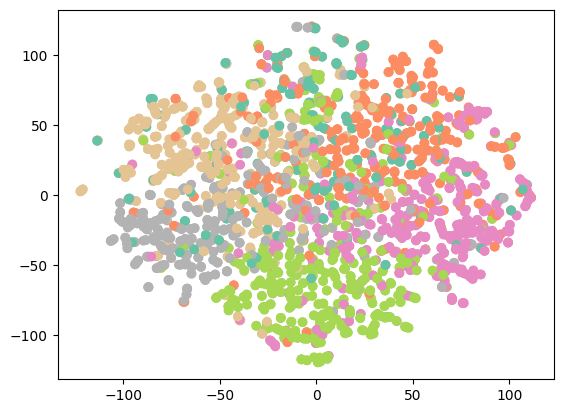

In [ ]:
exp.train_model()

In [ ]:
#make an eval model and convert dataset to data
exp.model.eval()
data= data[0]

# need a forward pass to find score and embed
score, embed = exp.model.forward(data.x, data.edge_index)

# need to apply softmax to convert scores to probability
runsoftmax = torch.nn.Softmax(dim=1)
nprob = runsoftmax(score)
trainmask = data.train_mask

# probability of only the training data points
nprob_train = nprob[trainmask]
nprob_train.shape

torch.Size([120, 6])

In [ ]:
# create various masks
highmask, lowmask, fullmask = find_new_mask(nprob_train,5)
highmask3, lowmask3, _ = find_new_mask(nprob_train,3)
highmask2, lowmask2, _ = find_new_mask(nprob_train,2)
high3low2 = torch.logical_or(highmask3, lowmask2)
high2low3 = torch.logical_or(highmask2, lowmask3)
highmask1, lowmask1, _ = find_new_mask(nprob_train,1)
highmask4, lowmask4, _ = find_new_mask(nprob_train,4)
high4low1 = torch.logical_or(highmask4, lowmask1)
high1low4 = torch.logical_or(highmask1, lowmask4)

tensor([ 6,  2, 12, 14,  5]) 5
tensor([ 3, 13,  4,  0, 10]) 5
tensor(5) tensor(5)
tensor([ 5, 16,  3, 19,  4]) 5
tensor([18,  2,  8, 14,  6]) 5
tensor(10) tensor(10)
tensor([ 8,  1,  5,  7, 13]) 5
tensor([11, 10, 16, 17,  4]) 5
tensor(15) tensor(15)
tensor([14, 11,  3, 17,  8]) 5
tensor([15,  6, 19, 16,  1]) 5
tensor(20) tensor(20)
tensor([ 3,  9, 16, 19,  4]) 5
tensor([ 8, 14,  1,  2,  0]) 5
tensor(25) tensor(25)
tensor([17, 18, 10,  7,  5]) 5
tensor([ 1, 13, 19,  9, 12]) 5
tensor(30) tensor(30)
New train mask for highest entropy points per class:
 tensor(30)
New train mask for lowest entropy points per class:
 tensor(30)
tensor([ 6,  2, 12]) 3
tensor([ 3, 13,  4]) 3
tensor(3) tensor(3)
tensor([ 5, 16,  3]) 3
tensor([18,  2,  8]) 3
tensor(6) tensor(6)
tensor([8, 1, 5]) 3
tensor([11, 10, 16]) 3
tensor(9) tensor(9)
tensor([14, 11,  3]) 3
tensor([15,  6, 19]) 3
tensor(12) tensor(12)
tensor([ 3,  9, 16]) 3
tensor([ 8, 14,  1]) 3
tensor(15) tensor(15)
tensor([17, 18, 10]) 3
tensor([ 1, 13,

In [ ]:
# 1> high
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, highmask)

Training Started...
Epoch : 5.00, Training Accuracy: 96.67, Testing Accuracy: 47.00
Epoch : 10.00, Training Accuracy: 96.67, Testing Accuracy: 53.90
Epoch : 15.00, Training Accuracy: 96.67, Testing Accuracy: 55.40
Epoch : 20.00, Training Accuracy: 96.67, Testing Accuracy: 56.20
Epoch : 25.00, Training Accuracy: 96.67, Testing Accuracy: 57.40
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 57.80
Epoch : 35.00, Training Accuracy: 96.67, Testing Accuracy: 56.90
Epoch : 40.00, Training Accuracy: 96.67, Testing Accuracy: 57.20
Epoch : 45.00, Training Accuracy: 96.67, Testing Accuracy: 56.50
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 56.30
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 56.00
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 56.10
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 55.60
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 55.60
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 55.70


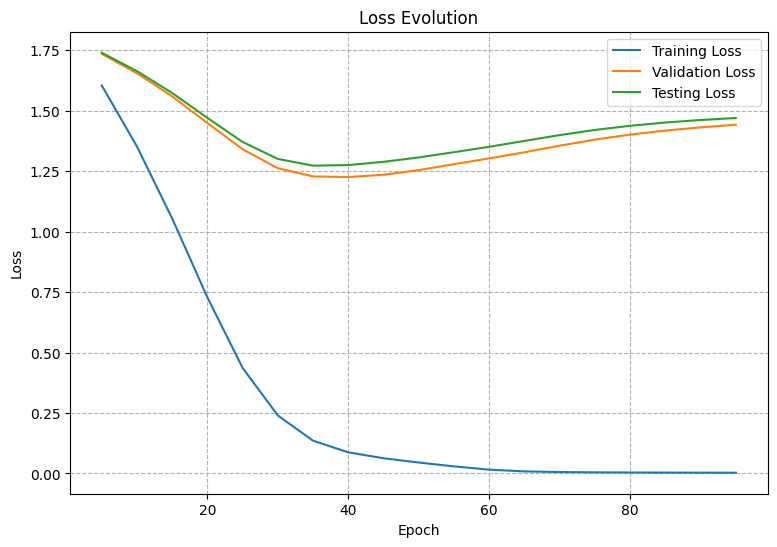

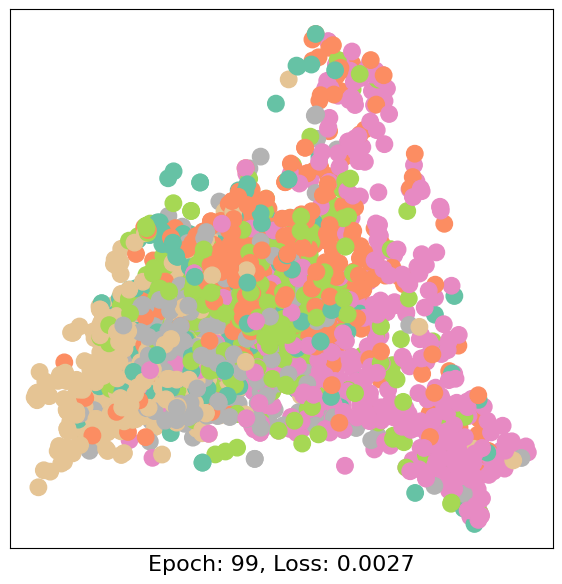

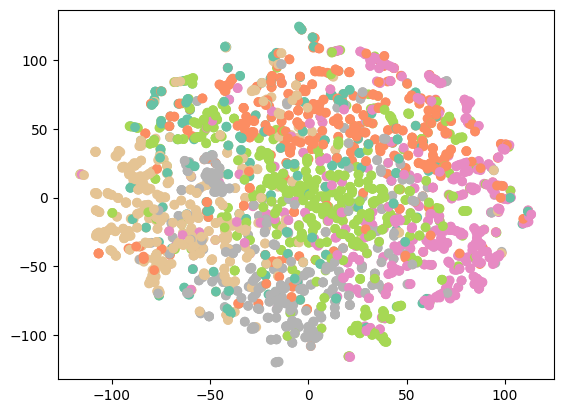

In [ ]:
exp_new_mask.train_model()

In [ ]:
# 2> low
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, lowmask)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 100.00, Testing Accuracy: 36.80
Epoch : 10.00, Training Accuracy: 100.00, Testing Accuracy: 44.60
Epoch : 15.00, Training Accuracy: 100.00, Testing Accuracy: 44.60
Epoch : 20.00, Training Accuracy: 100.00, Testing Accuracy: 43.80
Epoch : 25.00, Training Accuracy: 100.00, Testing Accuracy: 42.20
Epoch : 30.00, Training Accuracy: 100.00, Testing Accuracy: 41.90
Epoch : 35.00, Training Accuracy: 100.00, Testing Accuracy: 42.50
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 43.00
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 43.70
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 44.00
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 44.40
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 44.90
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 45.00
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 45.30
Epoch : 75.00, Training Accuracy: 100.00, Testing Accurac

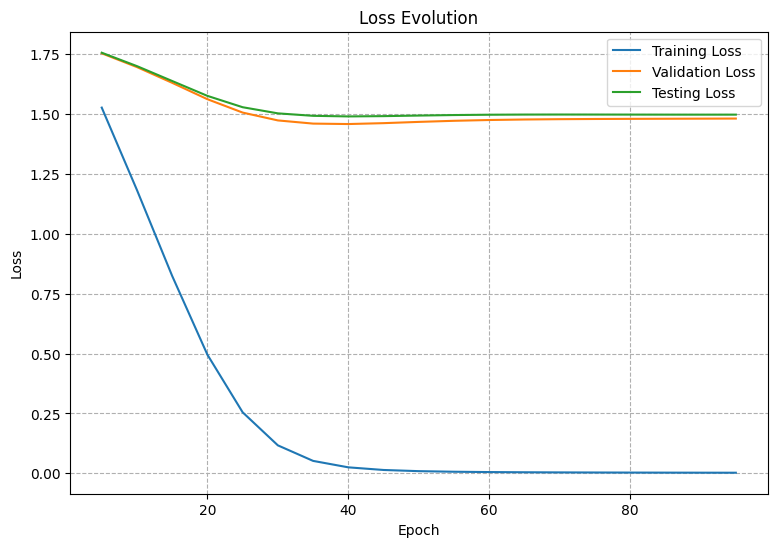

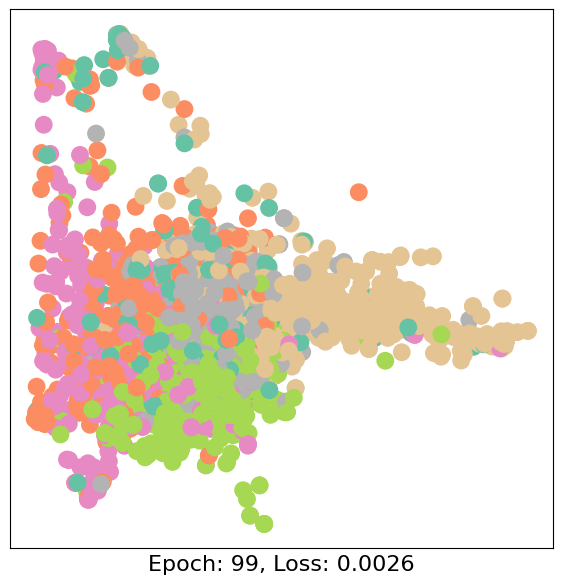

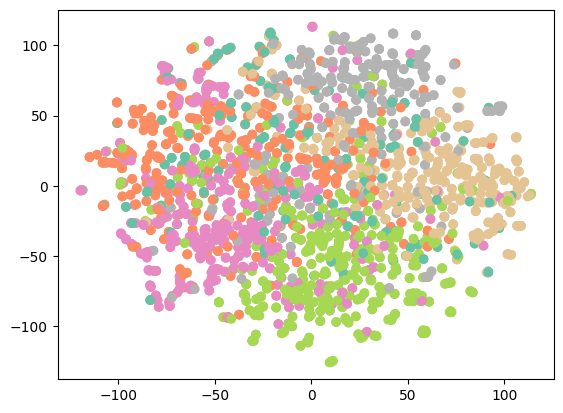

In [ ]:
exp_new_mask.train_model()

In [ ]:
#3> Mix high and low mask
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high3low2)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 93.33, Testing Accuracy: 39.50
Epoch : 10.00, Training Accuracy: 93.33, Testing Accuracy: 46.90
Epoch : 15.00, Training Accuracy: 93.33, Testing Accuracy: 48.20
Epoch : 20.00, Training Accuracy: 93.33, Testing Accuracy: 49.00
Epoch : 25.00, Training Accuracy: 93.33, Testing Accuracy: 50.30
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 50.00
Epoch : 35.00, Training Accuracy: 96.67, Testing Accuracy: 49.40
Epoch : 40.00, Training Accuracy: 96.67, Testing Accuracy: 49.70
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 49.70
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 49.00
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 48.80
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 49.20
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 48.80
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 48.90
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 48.70

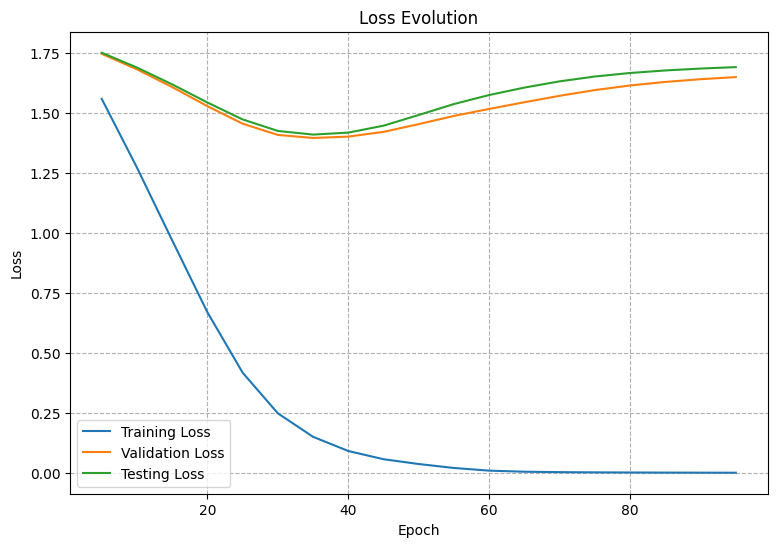

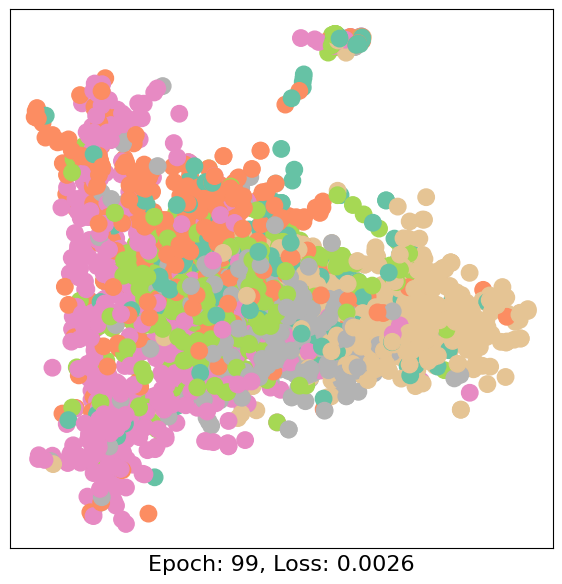

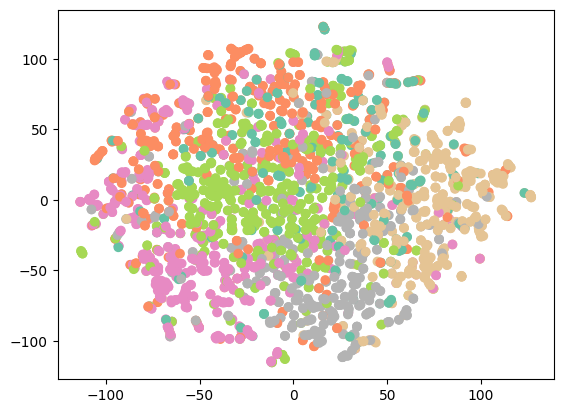

In [ ]:
exp_new_mask.train_model()

In [ ]:
#4> Mix high and low mask
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high2low3)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 100.00, Testing Accuracy: 37.40
Epoch : 10.00, Training Accuracy: 96.67, Testing Accuracy: 43.10
Epoch : 15.00, Training Accuracy: 93.33, Testing Accuracy: 44.30
Epoch : 20.00, Training Accuracy: 93.33, Testing Accuracy: 44.90
Epoch : 25.00, Training Accuracy: 93.33, Testing Accuracy: 43.90
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 41.50
Epoch : 35.00, Training Accuracy: 100.00, Testing Accuracy: 41.70
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 40.40
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 40.00
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 39.80
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 40.00
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 39.80
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 39.80
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 39.90
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 39

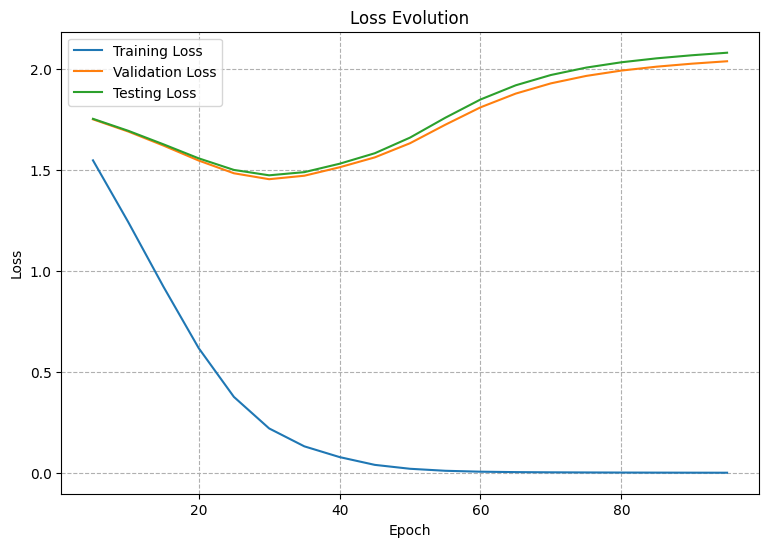

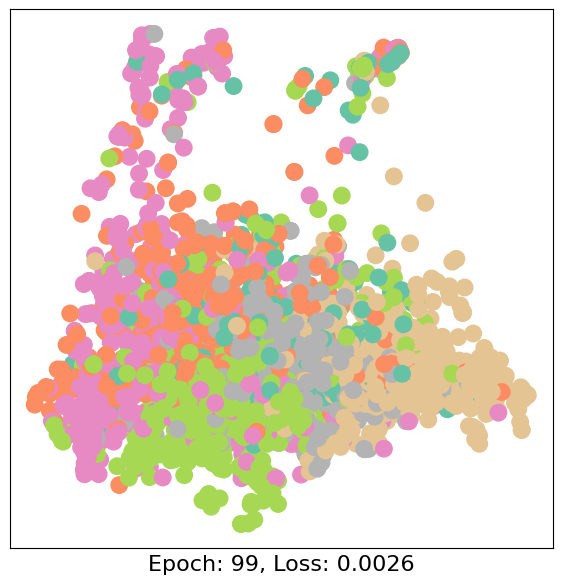

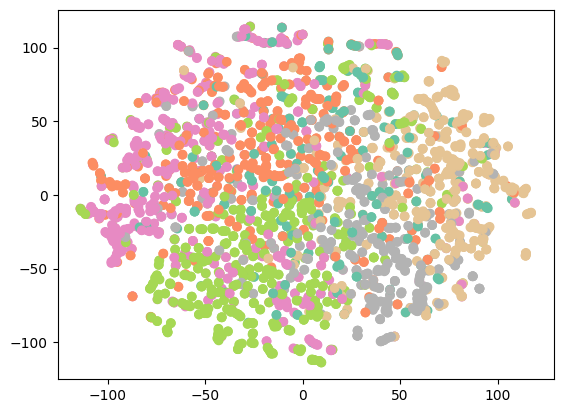

In [ ]:
exp_new_mask.train_model()

In [ ]:
# high4low1
#4> Mix high and low mask
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high4low1)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 96.67, Testing Accuracy: 46.70
Epoch : 10.00, Training Accuracy: 96.67, Testing Accuracy: 53.80
Epoch : 15.00, Training Accuracy: 96.67, Testing Accuracy: 56.10
Epoch : 20.00, Training Accuracy: 96.67, Testing Accuracy: 56.50
Epoch : 25.00, Training Accuracy: 96.67, Testing Accuracy: 56.00
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 56.40
Epoch : 35.00, Training Accuracy: 96.67, Testing Accuracy: 55.60
Epoch : 40.00, Training Accuracy: 96.67, Testing Accuracy: 54.30
Epoch : 45.00, Training Accuracy: 96.67, Testing Accuracy: 53.70
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 53.50
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 53.90
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 53.50
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 53.50
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 53.30
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 53.10


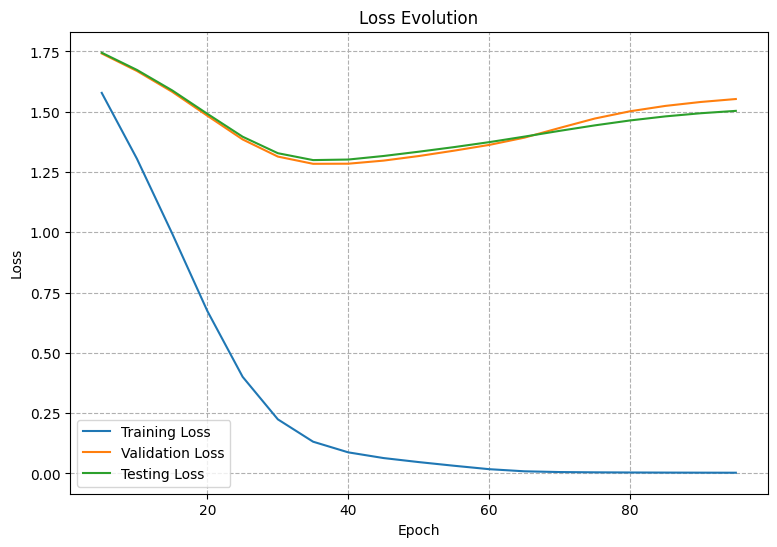

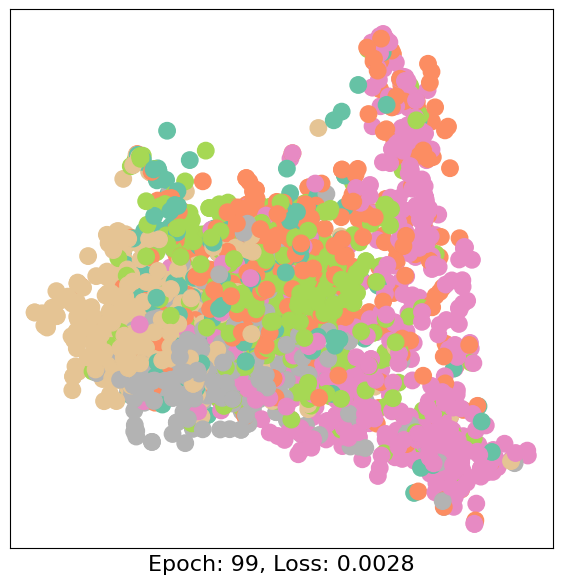

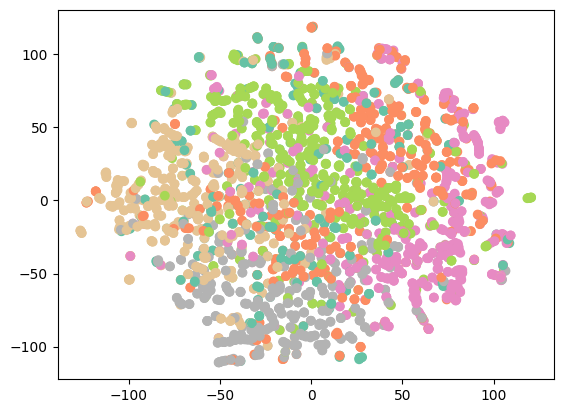

In [ ]:
exp_new_mask.train_model()

In [ ]:
# high4low1
#4> Mix high and low mask
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, high1low4)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 100.00, Testing Accuracy: 36.90
Epoch : 10.00, Training Accuracy: 100.00, Testing Accuracy: 43.70
Epoch : 15.00, Training Accuracy: 96.67, Testing Accuracy: 44.40
Epoch : 20.00, Training Accuracy: 96.67, Testing Accuracy: 43.60
Epoch : 25.00, Training Accuracy: 96.67, Testing Accuracy: 42.30
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 41.40
Epoch : 35.00, Training Accuracy: 100.00, Testing Accuracy: 40.90
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 40.80
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 40.50
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 40.60
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 41.10
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 40.90
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 41.20
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 41.60
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 4

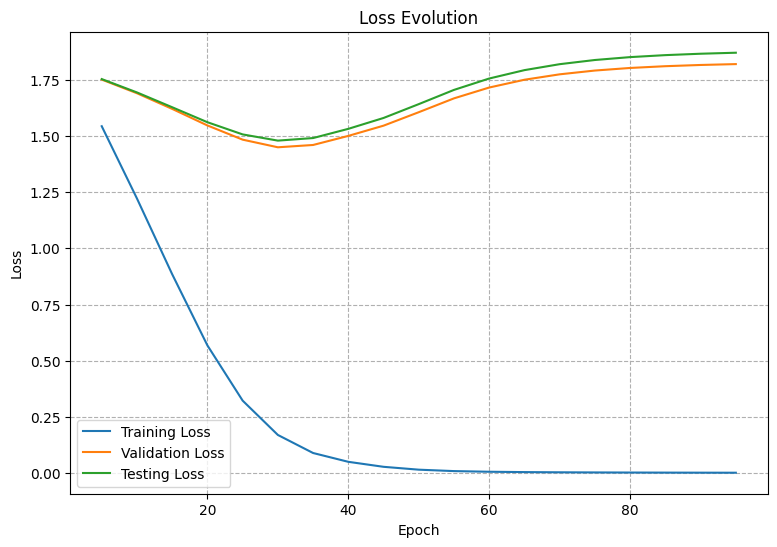

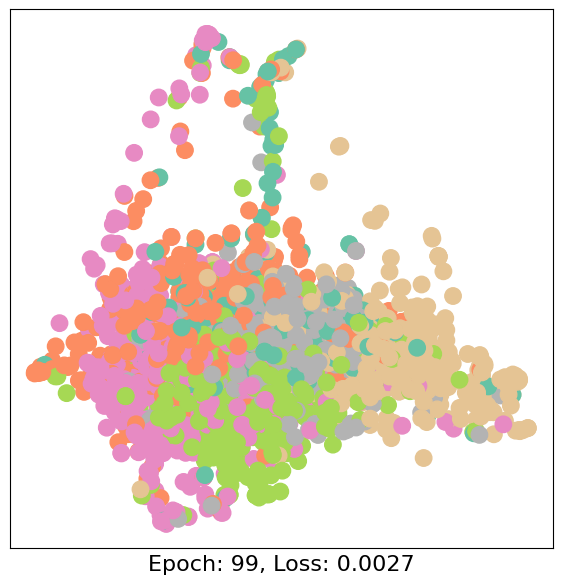

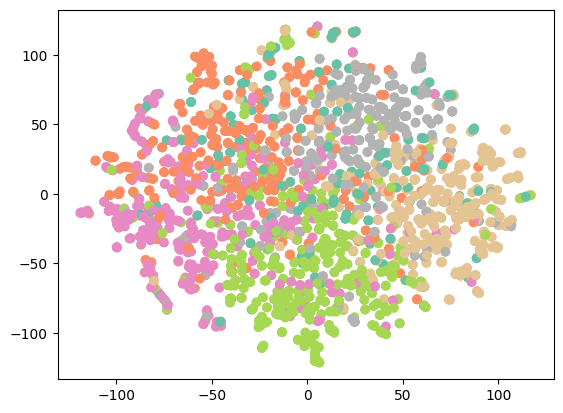

In [ ]:
exp_new_mask.train_model()

In [ ]:
highmask1, lowmask1, _ = find_new_mask(nprob_train,1)
highmask10, lowmask10, _ = find_new_mask(nprob_train,10)
highmask7, lowmask7, _ = find_new_mask(nprob_train,7)
highmask6, lowmask6, _ = find_new_mask(nprob_train,6)

highmask9, lowmask9, _ = find_new_mask(nprob_train,9)
highmask5, lowmask5, _ = find_new_mask(nprob_train,5)
highmask4, lowmask4, _ = find_new_mask(nprob_train,4)
highmask3, lowmask3, _ = find_new_mask(nprob_train,3)
highmask2, lowmask2, _ = find_new_mask(nprob_train,2)

tensor([6]) 1
tensor([3]) 1
tensor(1) tensor(1)
tensor([5]) 1
tensor([18]) 1
tensor(2) tensor(2)
tensor([8]) 1
tensor([11]) 1
tensor(3) tensor(3)
tensor([14]) 1
tensor([15]) 1
tensor(4) tensor(4)
tensor([3]) 1
tensor([8]) 1
tensor(5) tensor(5)
tensor([17]) 1
tensor([1]) 1
tensor(6) tensor(6)
New train mask for highest entropy points per class:
 tensor(6)
New train mask for lowest entropy points per class:
 tensor(6)
tensor([ 6,  2, 12, 14,  5, 16,  7, 15,  9, 11]) 10
tensor([ 3, 13,  4,  0, 10,  8, 19, 18, 17,  1]) 10
tensor(10) tensor(10)
tensor([ 5, 16,  3, 19,  4,  9, 15, 17, 13, 12]) 10
tensor([18,  2,  8, 14,  6, 10, 11,  7,  1,  0]) 10
tensor(20) tensor(20)
tensor([ 8,  1,  5,  7, 13, 15, 12,  3,  2,  0]) 10
tensor([11, 10, 16, 17,  4, 19,  9, 14,  6, 18]) 10
tensor(30) tensor(30)
tensor([14, 11,  3, 17,  8,  0,  4, 13,  9, 10]) 10
tensor([15,  6, 19, 16,  1,  7,  5,  2, 18, 12]) 10
tensor(40) tensor(40)
tensor([ 3,  9, 16, 19,  4, 18, 17, 13, 11, 10]) 10
tensor([ 8, 14,  1,  2, 

In [ ]:
# new mask
a = torch.logical_or(highmask3, lowmask1)
a = torch.logical_or(a,torch.logical_xor(lowmask10,lowmask9))
#a = torch.logical_or(a, torch.logical_xor(highmask5,highmask4))
#a = torch.logical_or(a,torch.logical_xor(highmask3, highmask2))

In [ ]:
#
#4> Mix high and low mask
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, a)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 96.67, Testing Accuracy: 48.80
Epoch : 10.00, Training Accuracy: 96.67, Testing Accuracy: 59.20
Epoch : 15.00, Training Accuracy: 96.67, Testing Accuracy: 62.00
Epoch : 20.00, Training Accuracy: 96.67, Testing Accuracy: 62.10
Epoch : 25.00, Training Accuracy: 96.67, Testing Accuracy: 61.40
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 60.60
Epoch : 35.00, Training Accuracy: 96.67, Testing Accuracy: 59.90
Epoch : 40.00, Training Accuracy: 96.67, Testing Accuracy: 58.80
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 58.20
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 58.00
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 57.50
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 57.50
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 57.50
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 57.50
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 57.40

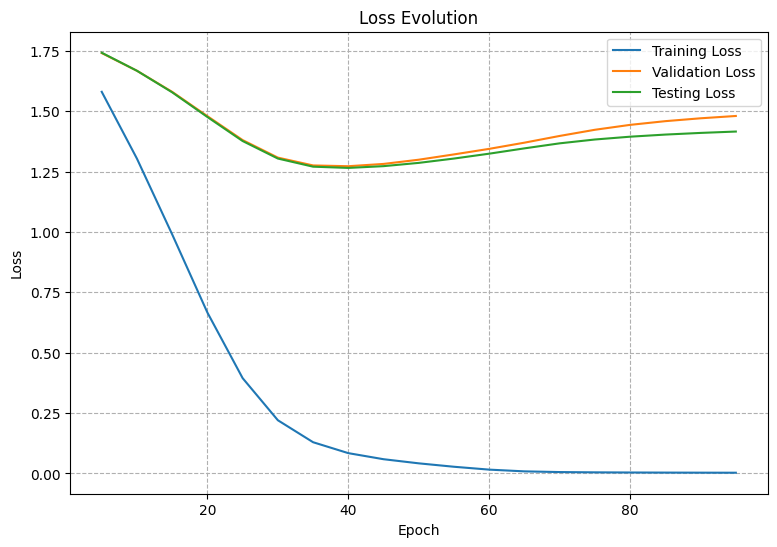

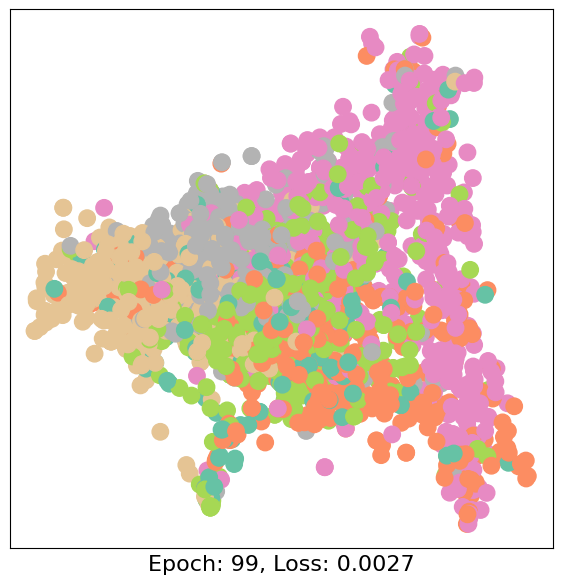

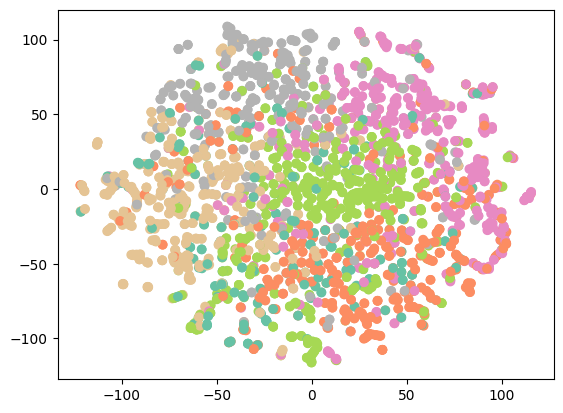

In [ ]:
exp_new_mask.train_model()

In [ ]:
a = torch.logical_or(highmask2, lowmask1)
a = torch.logical_or(a,torch.logical_xor(lowmask10,lowmask9))
a = torch.logical_or(a, torch.logical_xor(highmask7,highmask6))
#a = torch.logical_or(a,torch.logical_xor(highmask3, highmask2))

In [ ]:
data = Planetoid(root='data', name= "citeseer")
model_new = GAT(data.num_features,data.num_classes)
exp_new_mask = training(model_new, data, a)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Training Started...
Epoch : 5.00, Training Accuracy: 100.00, Testing Accuracy: 43.80
Epoch : 10.00, Training Accuracy: 100.00, Testing Accuracy: 52.50
Epoch : 15.00, Training Accuracy: 96.67, Testing Accuracy: 54.50
Epoch : 20.00, Training Accuracy: 96.67, Testing Accuracy: 53.80
Epoch : 25.00, Training Accuracy: 96.67, Testing Accuracy: 53.50
Epoch : 30.00, Training Accuracy: 96.67, Testing Accuracy: 53.00
Epoch : 35.00, Training Accuracy: 100.00, Testing Accuracy: 50.50
Epoch : 40.00, Training Accuracy: 100.00, Testing Accuracy: 50.10
Epoch : 45.00, Training Accuracy: 100.00, Testing Accuracy: 49.80
Epoch : 50.00, Training Accuracy: 100.00, Testing Accuracy: 49.30
Epoch : 55.00, Training Accuracy: 100.00, Testing Accuracy: 49.90
Epoch : 60.00, Training Accuracy: 100.00, Testing Accuracy: 50.40
Epoch : 65.00, Training Accuracy: 100.00, Testing Accuracy: 50.10
Epoch : 70.00, Training Accuracy: 100.00, Testing Accuracy: 49.70
Epoch : 75.00, Training Accuracy: 100.00, Testing Accuracy: 4

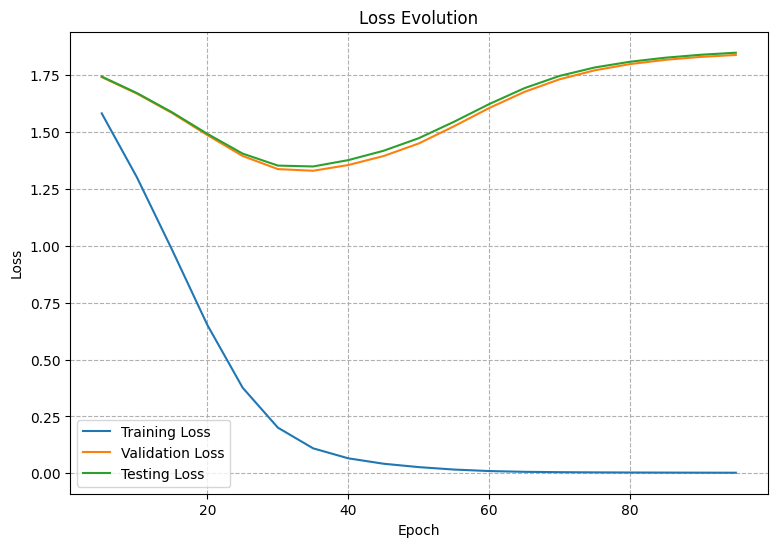

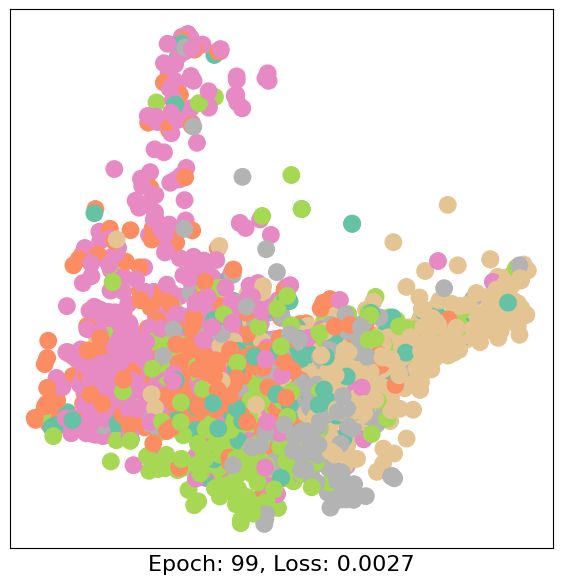

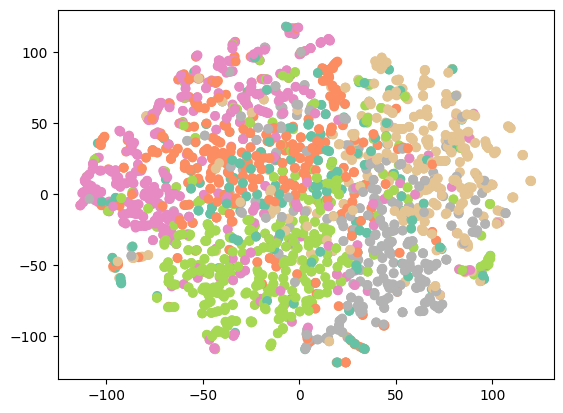

In [ ]:
exp_new_mask.train_model()

To do:
a) Structure for part-1: Finding which nodes are important (metrics used is entropy)
- Create a class that can experiment with different: 1)2 datasets, 2)3 seeds, 3)compression rate, 4)Models - GCN, GAT, Gsage, 5) Masks : only high, only low, Mix: 50:50, 20:80, 80:20, highDiverseLow
- For a dataset & seed, 
- a) FindEntropy: Use benchmark model to find entropy of points. Classify into high and low entropy. (STORE : List of (Entropy, nodeNumber) ) --- this will be used in part b
- b) createMasks: creates masks of various types.
- c) TrainModel: For each masks created, it trains model to find (best accuracy) during training.
- d) Output: 1) For each seed create one dataframe. Each Dataframe: Rows - Dataset/Compression, Col - Models/Masks + 2) Create a aggregate dataframe that store average. Store output every few iterations.

b) Structure for part-2: For each method, in which category (high, mid, low) do the synthetic nodes fit in.
- Create class that does the below for a) 2 datasets, b) different distill seeds, c) compression, d) 
- a) Reading the saved (A,X) of distillation methods and converting them into useful data structure for GNN model
- b) Passing through the bench model to find entropy of each node
- c) Assigning the (node, entropy) to high, low, mid : (rank the node based on closness to entropy of the stored list)
- d) Output: 1) Dataframe for each seed and aggregate dataframe for average. Store after every few iterations. Row: Dataset/compression, column: Method/(high,mid,low) 